In [1]:
# automatically reflect changes in imported modules
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

import utils
import utils.logging_config
utils.logging_config.set_log_level("debug")
import logging
logger = logging.getLogger("task1")

In [2]:
DATA_ROOT = Path('data')
DATA_NAME = 'data.txt'
NBINS = 30
CACHE_ROOT = Path('.cache')

In [3]:
points, columns = utils.load_data(DATA_ROOT / DATA_NAME)
logger.debug(f"Fetched {points.shape[0]} points, columns: {columns}")
# reorder the columns to match the expected order (x, y, z, mass)
particles = points[:, [2, 3, 4, 1]]

# particles = particles[::10, ...]
# particles = particles[:5000, ...]
# particles = utils.remove_outliers(particles)
# logger.warning(f"Reduced selection to {particles.shape[0]} particles")
# TODO: make sure this is not executed in the final version

17:09:41 - utils.load - Loaded 50010 rows and 10 columns from data/data.txt
17:09:41 - task1 - Fetched 50010 points, columns: ['ID', 'MASS', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'SOFTENING', '?']


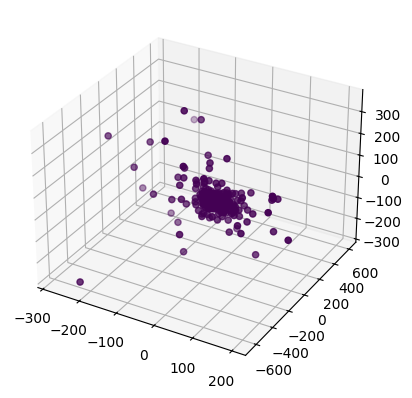

In [4]:
# plot the distribution of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(particles[:,0], particles[:,1], particles[:,2], cmap='viridis', c=particles[:,3])
plt.show()

### Choice of units
Recap of the particle properties:
- $\sim 10^4$ particles
- spherical distribution

$\implies$ this seems to be a **globular cluster**

In [5]:
# Set G = 1
G = 1


# Since we have a globular cluster, we can use typical values
M_TOT = 1e5 * u.M_sun
R_TOT = 20 * u.pc

# Rescale the units of the particles
M_particles = particles[:,3].sum()
R_particles = np.max(np.linalg.norm(particles[:, :3], axis=1))
logger.info(f"Considering a globular cluster - total mass of particles: {M_particles}, maximum radius of particles: {R_particles}")
m_scale = M_TOT / M_particles
r_scale = R_TOT / R_particles
utils.seed_scales(r_scale, m_scale)



# ### Plot again with scales
# positions = utils.apply_units(particles[:, :3], "position")
# masses = utils.apply_units(particles[:, 3], "mass")
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# sc = ax.scatter(positions[:,0], positions[:,1], positions[:,2], cmap='viridis', c=masses)
#
# ax.set_xlabel(f'x [{positions.unit}]')
# ax.set_ylabel(f'y [{positions.unit}]')
# ax.set_zlabel(f'z [{positions.unit}]')
# cbar = plt.colorbar(sc, ax=ax, pad=0.1)
# cbar.set_label(f'Mass [{masses.unit}]')
#
# plt.show()

17:09:43 - task1 - Considering a globular cluster - total mass of particles: 4622219.258999999, maximum radius of particles: 724.689657812915
17:09:43 - utils.units - Set scales: M_SCALE = 0.022 solMass, R_SCALE = 0.028 pc


17:09:43 - utils.particles - Half mass radius: 0.1887071270700712 for 25004th particle of 50010
17:09:43 - task1 - Scale length: a=0.078, total mass: m=4.6e+06


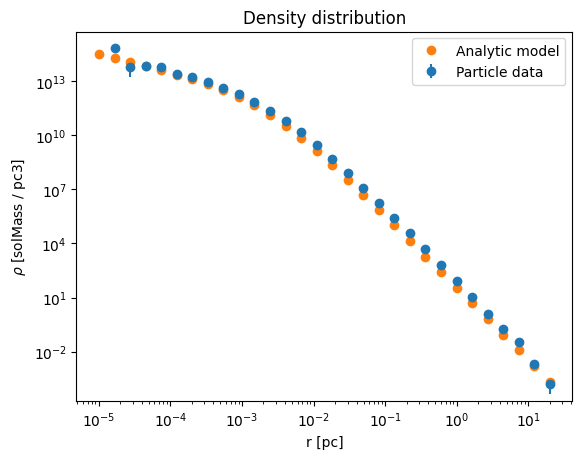

In [6]:
all_r = utils.r_distribution(particles)
rbins = np.logspace(np.log10(np.min(all_r)), np.log10(np.max(all_r)), NBINS, endpoint=True)

## Using the Hernquist model with parameters M and a
m = M_particles
a = utils.half_mass_radius(particles) / (1 + np.sqrt(2))
logger.debug(f"Scale length: {a=:.2g}, total mass: {m=:.2g}")
rho_t = utils.model_density_distribution(rbins, m, a)

## Numerical density distribution
rho, err = utils.density_distribution(rbins, particles, ret_error=True)

## Add the units
rho = utils.apply_units(rho, "density")
err = utils.apply_units(err, "density")
rho_t = utils.apply_units(rho_t, "density")
rbins = utils.apply_units(rbins, "position")


plt.figure()
plt.title('Density distribution')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'r [{rbins.unit}]')
plt.ylabel(f'$\\rho$ [{rho.unit}]')
plt.errorbar(rbins.value, rho.value, yerr=err.value, fmt='o', label="Particle data")
plt.plot(rbins.value, rho_t.value, 'o', label="Analytic model")
plt.legend()
plt.show()

## Note that by construction, the first shell contains no particles
## => the numerical density is zero there
## Having more bins means to have shells that are nearly empty
## => the error is large, NBINS = 30 is a good compromise

In [7]:
### Direct N body force computation and comparison with analytical model
epsilon = utils.mean_interparticle_distance(particles)


epsilon_range = np.logspace(-3, 3, 7)
n_squared_forces = []
for e in epsilon_range:
    n_particles = particles.shape[0]
    cache_file = CACHE_ROOT / f"n_squared_forces__n_{n_particles}__softening_multiplier_{e:.0f}.npy"
    try:
        f = np.load(cache_file)
    except FileNotFoundError:
        f = utils.n_body_forces(particles, G, e * epsilon)
        np.save(cache_file, f)
        logger.debug(f"Saved forces to {cache_file}")
    n_squared_forces.append(f)

analytical_force = utils.analytical_forces(particles)

17:09:44 - utils.particles - Half mass radius: 0.1887071270700712 for 25004th particle of 50010
17:09:44 - utils.particles - Number of particles within half mass radius: 25004 of 50010
17:09:44 - utils.particles - Found mean interparticle distance: 0.010402746349924056
17:09:44 - utils.forces_basic - Computing forces for 50010 particles using n^2 algorithm (using softening=1e-05)
17:09:55 - utils.forces_basic - Particle 5000 done
17:10:10 - utils.forces_basic - Particle 10000 done
17:10:24 - utils.forces_basic - Particle 15000 done
17:10:32 - utils.forces_basic - Particle 20000 done
17:10:39 - utils.forces_basic - Particle 25000 done
17:10:47 - utils.forces_basic - Particle 30000 done
17:10:55 - utils.forces_basic - Particle 35000 done
17:11:02 - utils.forces_basic - Particle 40000 done
17:11:09 - utils.forces_basic - Particle 45000 done
17:11:16 - utils.forces_basic - Particle 50000 done
17:11:16 - task1 - Saved forces to .cache/n_squared_forces__n_50010__softening_multiplier_0.npy
17

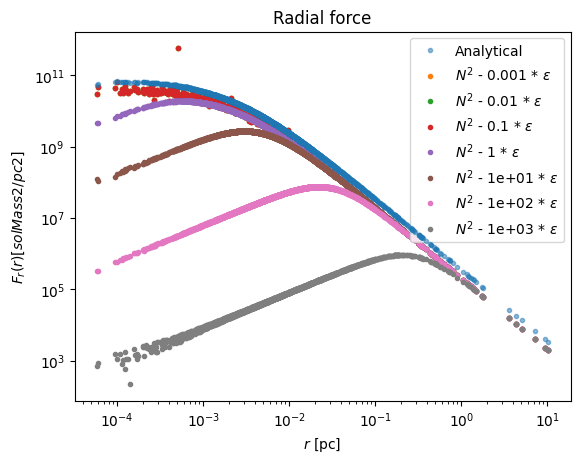

In [8]:
SKIP_N = 20
## Plot the radial force behaviour
r = np.linalg.norm(particles[:,:3], axis=1)
r = utils.apply_units(r, "position")

plt.figure()
f_analytical = np.linalg.norm(analytical_force, axis=1)
f_analytical = utils.apply_units(f_analytical, "force")
plt.plot(r.value[::SKIP_N], f_analytical.value[::SKIP_N], '.', label="Analytical", zorder=10, alpha=0.5)

for e, f in zip(epsilon_range, n_squared_forces):
    f_abs = np.linalg.norm(f, axis=1)
    f_abs = utils.apply_units(f_abs, "force")
    plt.plot(r.value[::SKIP_N], f_abs.value[::SKIP_N], '.', label=f"$N^2$ - {e:.1g} * $\\epsilon$")


plt.title('Radial force')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'$r$ [{r.unit}]')
plt.ylabel(f'$F_r(r) [{f_analytical.unit}]$')
plt.legend()
plt.show()



17:17:43 - utils.forces_basic - Computing forces for 49755 particles using spherical approximation
17:17:43 - utils.forces_basic - Particle 0 done
17:17:45 - utils.forces_basic - Particle 5000 done
17:17:46 - utils.forces_basic - Particle 10000 done
17:17:49 - utils.forces_basic - Particle 15000 done
17:17:51 - utils.forces_basic - Particle 20000 done
17:17:54 - utils.forces_basic - Particle 25000 done
17:17:57 - utils.forces_basic - Particle 30000 done
17:17:59 - utils.forces_basic - Particle 35000 done
17:18:01 - utils.forces_basic - Particle 40000 done
17:18:03 - utils.forces_basic - Particle 45000 done
17:18:05 - utils.forces_mesh - Computing forces for 49755 particles using mesh [mapping=particle_to_cells_nn, n_grid=405]
17:18:06 - utils.forces_mesh - Using mesh spacing: 0.12475990099009948
17:18:13 - utils.forces_mesh - Proceeding to poisson equation with rho_hat.shape=(405, 405, 405), k_sr.shape=(405, 405, 405)
17:18:20 - utils.forces_mesh - Got phi with: (405, 405, 405), 967477

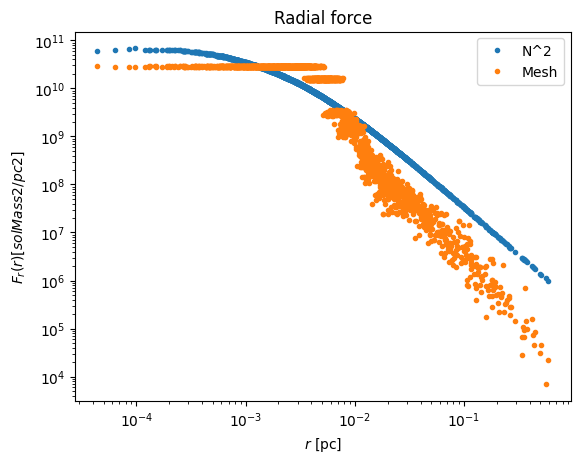

In [9]:
## For fun, do this with the mesh solver as well:
particles = utils.remove_outliers(particles)
r = np.linalg.norm(particles[:,:3], axis=1)
r = utils.apply_units(r, "position")

plt.figure()
f_nsquare = utils.analytical_forces(particles)
f_abs = np.linalg.norm(f_nsquare, axis=1)
f_abs = utils.apply_units(f_abs, "force")
plt.plot(r.value[::SKIP_N], f_abs.value[::SKIP_N], '.', label="N^2")

f_mesh = utils.mesh_forces_v2(particles, G, 405, utils.particle_to_cells_nn)
f_abs = np.linalg.norm(f_mesh, axis=1)
f_abs = utils.apply_units(f_abs, "force")
plt.plot(r.value[::SKIP_N], f_abs.value[::SKIP_N], '.', label="Mesh")

plt.title('Radial force')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'$r$ [{r.unit}]')
plt.ylabel(f'$F_r(r) [{f_analytical.unit}]$')
plt.legend()
plt.show()


#### Discussion
- basic $N^2$ matches analytical solution without dropoff. but: noisy data from "bad" samples
- $N^2$ with softening matches analytical solution but has a dropoff. No noisy data.
    - softening $\approx 1 \varepsilon$ is a sweet spot since the dropoff is "late"

### Relaxation time

For an estimate of the crossing time we use the half mass radius and the circular velocity at the half mass radius.

$\implies$ the crossing time is of order radius / velocity

In [10]:
## Computes the relaxation timescale of a set of particles using the velocity at the half mass radius.

# enclosed mass at half mass radius
m_half = np.sum(particles[:, 3]) / 2
r_half = utils.half_mass_radius(particles)
# set the units
m_half = utils.apply_units(m_half, "mass")
r_half = utils.apply_units(r_half, "position")

v_c = np.sqrt(G * m_half / r_half)
logger.info(f"Central velocity @ HM {v_c}")

t_c = r_half / v_c
logger.info(f"Crossing time for half mass system: {t_c:.2g}")
# TODO: how to treat this unit?

## Using the derived formula for the relaxation timescale
# Compute the relaxation timescale through the estimate
# t_relax = t_c *n_relax = t_c * N / (10 * log(N))
n = particles.shape[0]
n_relax = n / (10 * np.log(n))
t_rel = t_c * n_relax
logger.info(f"Direct estimate of the relaxation timescale: {t_rel:.2g}")


17:18:24 - utils.particles - Half mass radius: 0.18682694059016222 for 24877th particle of 49755
17:18:24 - task1 - Central velocity @ HM 3106.1056463446503 solMass(1/2) / pc(1/2)
17:18:24 - task1 - Crossing time for half mass system: 1.7e-06 pc(3/2) / solMass(1/2)
17:18:24 - task1 - Direct estimate of the relaxation timescale: 0.00076 pc(3/2) / solMass(1/2)


#### Discussion


The estimate for $n_{relax}$ comes from the contribution of each star-star encounter to the velocity dispersion. This depends on the perpendicular force

![Pasted image 20250118155501.png](<attachment:Pasted image 20250118155501.png>)

The full integration of the force along the path of the star reduces to the main contribution at the closest approach (distance $b$):
$$
\delta v \approx \frac{2 G m}{b} \to \delta v \approx \frac{2 G m}{b + \varepsilon}
$$
$\implies$ a bigger softening length leads to a smaller $\delta v$.

Using $n_{relax} = \frac{\delta v^2}{v^2}$, and knowing that the value of $v^2$ is derived from the Virial theorem (i.e. unaffected by the softening length), we can see that $n_{relax}$ scales like $\varepsilon^{-2}$.

##### Effect
- The relaxation time decreases with increasing softening length
- From the integration over all impact parameters $b$ even $b_{min}$ is chosen to be larger than $\varepsilon$ $\implies$ expect only a small effect on the relaxation time

#TODO : The softening dampens the change of velocity => time to relax is longer
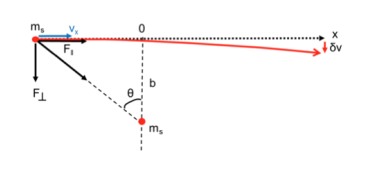